## Explore training data

<a target="_blank" href="https://colab.research.google.com/github/Pappa/bandido/blob/main/notebooks/crypto/02-tf-agents-bandit-train.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
try:
  import tf_agents
except ImportError:
  %pip install tf-agents
  %pip install tf-keras

2025-07-18 23:13:47.354295: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 23:13:47.381228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-18 23:13:47.381245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-18 23:13:47.382108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-18 23:13:47.386884: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from trading_utils import preprocess_data, create_wide_format_data, SYMBOLS
from trading_env import CryptoTradingEnvironment

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Data and Model Paths
DATA_FILEPATH = 'data/ohlcv.csv.gz'
POLICY_SAVE_PATH = 'policy'

# Model Hyperparameters
CONTEXT_LENGTH = 10
NUM_TRAINING_STEPS = 1000  # Increased for more meaningful training
ALPHA = 1.0 # LinUCB exploration parameter
TEST_SIZE = 0.2

TECHNICAL_FEATURES = ['rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_percent_b', 'bb_bandwidth']
TECHNICAL_FEATURES = ['rsi', 'macd_hist']

# 1. Load Data
df = pd.read_csv(DATA_FILEPATH, compression='gzip', parse_dates=['timestamp']) #.set_index('timestamp')
all_data = preprocess_data(df)
observation_df, prices_df = create_wide_format_data(
    all_data, 
    symbols=SYMBOLS, 
    features=TECHNICAL_FEATURES
)

print(f"all_data: {len(all_data)}")

train_observation_df, test_observation_df = train_test_split(
    observation_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

train_prices_df, test_prices_df = train_test_split(
    prices_df, 
    test_size=TEST_SIZE, 
    shuffle=False
)

scaler = StandardScaler()
train_observation_scaled_df = pd.DataFrame(scaler.fit_transform(train_observation_df), columns=train_observation_df.columns)
test_observation_scaled_df = pd.DataFrame(scaler.transform(test_observation_df), columns=train_observation_df.columns)

print("observation training data")
display(train_observation_scaled_df.head(5))

print("price training data")
display(train_prices_df.head(5))

all_data: 67680
observation training data


,BTC_rsi,BTC_macd_hist,DOGE_rsi,DOGE_macd_hist,XRP_rsi,XRP_macd_hist,ETH_rsi,ETH_macd_hist,SOL_rsi,SOL_macd_hist
0,2.946344,0.578759,3.163272,0.232872,2.212194,0.154695,2.811983,0.585831,2.795379,0.905617
1,3.035687,0.776174,2.568838,0.213441,2.410936,0.175700,2.853477,0.661077,2.032522,0.804257
2,2.792215,0.821000,2.681089,0.203588,2.463747,0.183967,2.654962,0.640165,2.070339,0.700204
3,2.477183,0.756562,2.144852,0.164566,2.026307,0.162470,2.424229,0.554550,2.087366,0.585394
4,2.890716,0.962124,2.433619,0.164393,2.325416,0.164937,2.681319,0.617406,2.527857,0.676552


price training data


symbol,BTC,DOGE,XRP,ETH,SOL
timestamp,,,,,
2024-01-01 19:00:00,43517.99,0.09181,0.6258,2337.26,108.81
2024-01-01 20:00:00,43687.86,0.09153,0.6276,2340.98,107.88
2024-01-01 21:00:00,43619.21,0.09175,0.6282,2337.83,108.04
2024-01-01 22:00:00,43529.93,0.09150,0.6269,2334.21,108.09
2024-01-01 23:00:00,44179.55,0.09199,0.6294,2352.04,109.91


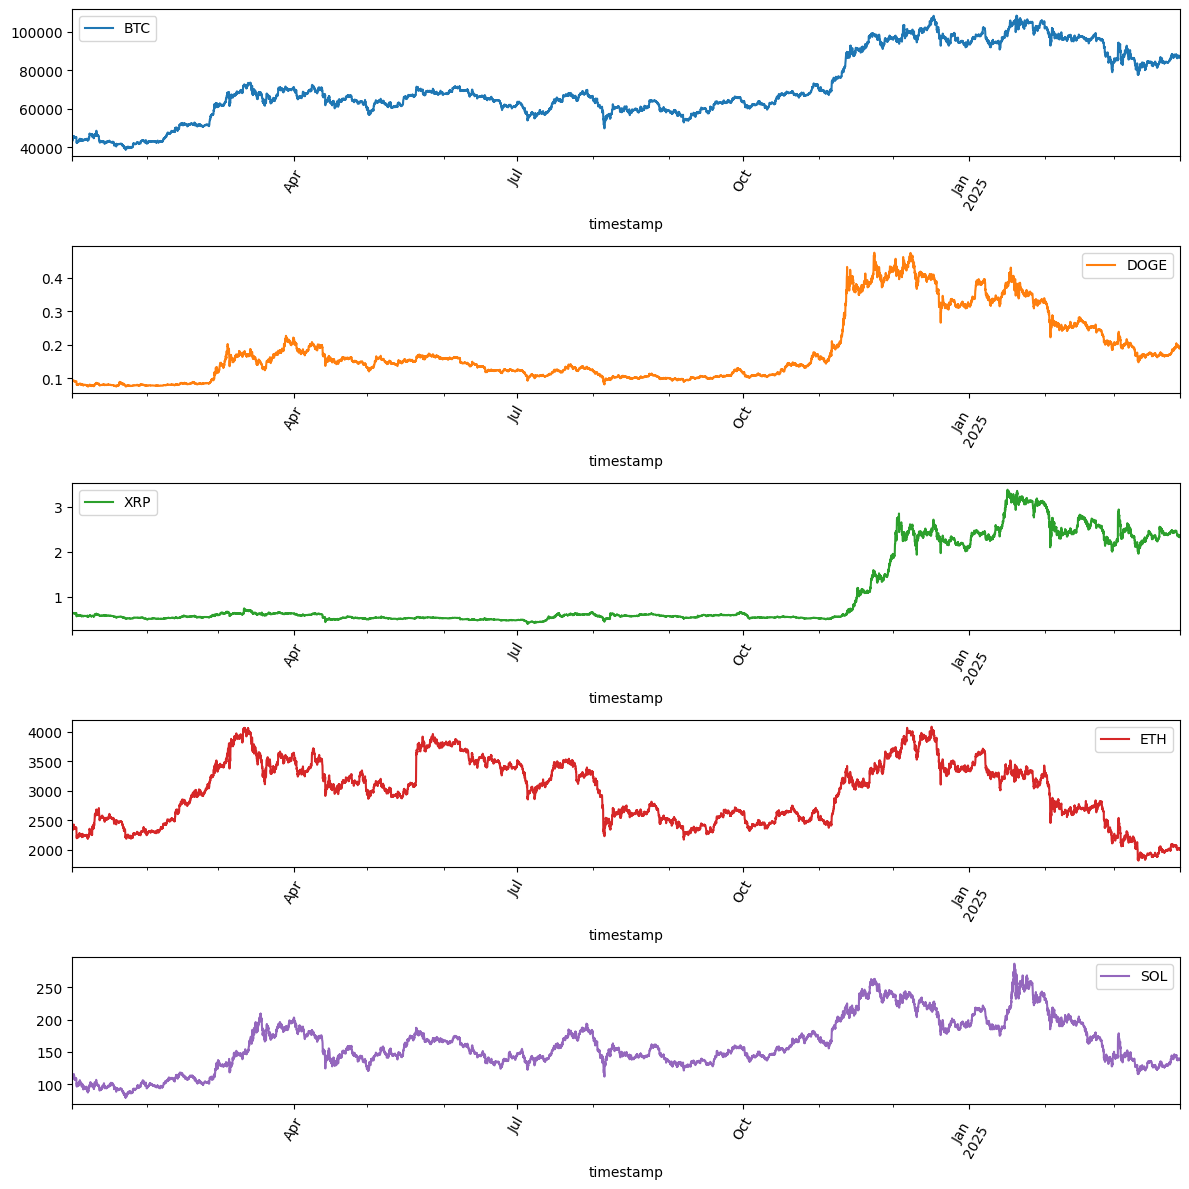

In [10]:
fig, a = plt.subplots(5, 1, figsize=(12, 12), tight_layout=True)
train_prices_df.plot(ax=a, subplots=True, rot=60);

In [3]:
# 2. Setup Environment
crypto_env = CryptoTradingEnvironment(
    observation_df=train_observation_scaled_df,
    prices_df=train_prices_df,
    symbols=SYMBOLS
)

tf_env = tf_py_environment.TFPyEnvironment(crypto_env)

# 3. Setup Agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    alpha=ALPHA,
    dtype=tf.float32
)

# 4. Setup Metrics and Oracle
def optimal_reward_oracle(observation: np.ndarray) -> np.float32:
    """
    Calculates the best possible reward for the current step by looking ahead.
    This "perfect foresight" oracle is used for calculating regret.

    NOTE: The 'observation' argument is unused but required by the metric's API.
    """
    
    # 2. Get the current step index from the environment's state.
    current_step = crypto_env.current_step
    price_data = crypto_env.price_data
    
    # 3. Handle the edge case where we are at the end of the data.
    # We can't look one step into the future.
    if current_step >= len(price_data) - 1:
        return 0.0

    # 4. Calculate the reward for every possible action to find the maximum.
    all_possible_rewards = []
    num_actions = crypto_env.action_spec().maximum + 1
    
    for action in range(num_actions):
        # Decode the action into a symbol and a trade type
        crypto_index = action // 3
        trade_type_idx = action % 3  # 0: BUY, 1: HOLD, 2: SELL
        
        # The reward for a HOLD action is always 0.
        if trade_type_idx == 1:
            all_possible_rewards.append(0.0)
            continue
            
        symbol_to_trade = crypto_env.symbols[crypto_index]
        
        current_price = price_data.iloc[current_step][symbol_to_trade]
        next_price = price_data.iloc[current_step + 1][symbol_to_trade]
        # next_price_change = price_data.iloc[current_step + 1][symbol_to_trade]

        
        # Calculate the reward for this specific BUY or SELL action
        if trade_type_idx == 0:  # BUY
            reward = (next_price - current_price) / current_price
        else:  # SELL (trade_type_idx == 2)
            reward = (current_price - next_price) / current_price
        
        all_possible_rewards.append(reward)
        
    # 5. Return the maximum possible reward from all actions.
    return np.max(all_possible_rewards).astype(np.float32)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_oracle)

class ShowProgress:
    def __init__(self, total, interval=50):
        self.counter = 0
        self.total = total
        self.interval = interval
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % self.interval == 0:
            print("\r{}/{} Reward: {}".format(self.counter, self.total, np.round(trajectory.reward.numpy()[0], 6)), end="")

class RewardCollector():
    def __init__(self):
        self._rewards = []
    def __call__(self, trajectory):
        self._rewards.append(trajectory.reward[0])
    @property
    def rewards(self):
        return np.array(self._rewards)

# 5. Setup Driver
def train_step(trajectory):
    if not trajectory.is_last():
        time_axised_trajectory = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1), trajectory)
        agent.train(time_axised_trajectory)
        
reward_collector = RewardCollector()

driver = dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.policy,
    # num_steps=len(SYMBOLS) * 3,
    num_steps=1,
    observers=[train_step, regret_metric, ShowProgress(NUM_TRAINING_STEPS), reward_collector]
)

# 6. Run Training

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=len(SYMBOLS) * 3,
    max_length=1)

regret_values = []

for _ in range(NUM_TRAINING_STEPS):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())


# print(f"\nStarting training for {driver._num_steps} steps...")
# # driver.run()
# print("\nTraining finished.")

# 7. Save Policy
print(f"\nSaving the trained policy to: {POLICY_SAVE_PATH}")
saver = policy_saver.PolicySaver(agent.policy)
saver.save(POLICY_SAVE_PATH)
print("Policy saved successfully.")

# 8. Report Results
cumulative_regret = regret_metric.result().numpy()
print(regret_metric)
print(f"\nCumulative Regret vs. Perfect Foresight Oracle: {cumulative_regret:.4f}")

2025-07-18 23:13:49.668848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-18 23:13:49.676281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-18 23:13:49.679502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
1000/1000 Reward: 0.0006469999789260328
Saving the trained policy to: policy


INFO:tensorflow:Assets written to: policy/assets


/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/assets


Policy saved successfully.

Cumulative Regret vs. Perfect Foresight Oracle: 0.0018


Text(0.5, 0, 'Number of Iterations')

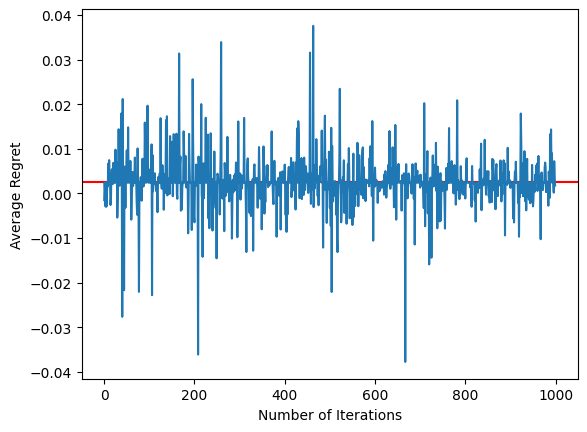

In [4]:
average_regret = np.mean(regret_values)
plt.axhline(y=average_regret, color='r', linestyle='-')
plt.plot(regret_values)
plt.ylabel('Average Regret')
plt.xlabel('Number of Iterations')

Text(0.5, 0, 'Number of Iterations')

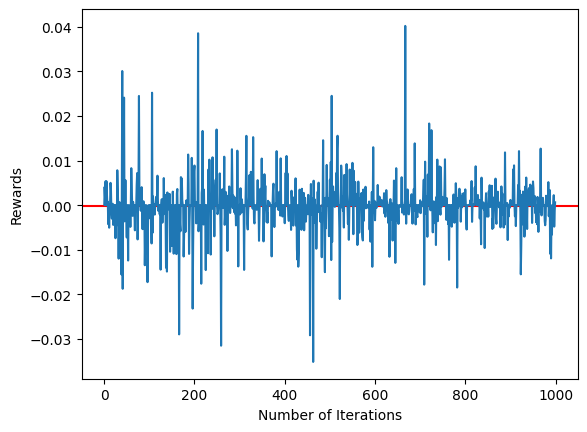

In [5]:
rewards = reward_collector.rewards
average_reward = rewards.mean()

plt.axhline(y=average_reward, color='r', linestyle='-')
plt.plot(rewards)
plt.ylabel('Rewards')
plt.xlabel('Number of Iterations')